In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
os.chdir("..")
os.getcwd()

from platform import python_version
print(python_version())

import importlib.util

#spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src\\data_prep.py")
spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src/data_prep.py")
prep_data = importlib.util.module_from_spec(spec_data_pred)
spec_data_pred.loader.exec_module(prep_data)

#spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src\\plotting_printing.py")
spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src/plotting_printing.py")
plotting_printing = importlib.util.module_from_spec(spec_plotting_printing)
spec_plotting_printing.loader.exec_module(plotting_printing)

3.8.10


In [ ]:

import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import numpy as np 

import pandas as pd
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics

props = dict(boxstyle='round', facecolor='white', alpha=0.5)



### Purpose of this notebook: 

# PoC for a multidimensional power law approach for training dataset size prediction.

* Using emnist balanced data
* and a standard cnn architecture
* Varying the number of images per class with different number of overall training dataset sizes
* Collect accuracies for each experiment
* Fit a power law with a linear combination as input.

# statistical models considered:

* ### power law: 
    * Just using last epoch
    * Using all epochs
    * ref: Just using overall training dataset size with last epoch


# Data prep

* reading in csv data
* filter to only keep epochs $>10$
* normalize

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [2]:
model_type = "powerlaw_all_epochs"

In [3]:
#results_full_training = pd.read_csv("csv_files/Cifar10_acc_full_train_10_iterations_20230714.csv")
#results_full_training.head(20)
#mask = results_full_training.epoch == 195
#results_full_training[mask]

In [4]:
results = pd.read_csv("csv_files/emnist_train_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231103.csv")
results_val = pd.read_csv("csv_files/emnist_val_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231117.csv")
min_epoch = 15


In [5]:
112800 / 47 # number of images per class in full dataset
100000/47

2127.659574468085

In [6]:
results.head(2)
results.epochs_trained.unique()

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90])

In [7]:
mask = results.epochs_trained >= min_epoch
results = results[mask].reset_index(drop=True)
mask = results_val.epochs_trained >= min_epoch
results_val = results_val[mask].reset_index(drop=True)

classes = results.columns.tolist()[2:-1]
#classes
print(classes)
results["total_training_size"] = results[classes].sum(axis=1)
results_orig = results.copy()
results_val["total_training_size"] = results_val[classes].sum(axis=1)
results.head(4)


print(results[["accs"] + classes + ["epochs_trained", "total_training_size"]].iloc[:5, :].to_latex(float_format="{:.2f}".format))

### constructing a pred dataset: 
results_pred = results[["training_times"] + classes + ["epochs_trained", "total_training_size"]].copy()
row = {c: 2400 for c in classes}
row["epochs_trained"] = 90
row["total_training_size"] = 112800 
row["training_times"] = 100
results_pred = results_pred.append(row, ignore_index=True)
row = {c: 2400 for c in classes}
row["training_times"] = 45
row["epochs_trained"] = 70
row["total_training_size"] =  112800
results_pred = results_pred.append(row, ignore_index=True)
results_pred = results_pred.iloc[-2:,:].reset_index(drop=True)

for c_max in classes:
    row = {c: 2120 for c in classes}
    row[c_max] = 2400
    row["epochs_trained"] = 90
    row["training_times"] = 100
    row["total_training_size"] =  2120 * 47 + 2400
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 70
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 30
    results_pred = results_pred.append(row, ignore_index=True)
    
for c_max in classes:
    row = {c: 1800 for c in classes}
    row[c_max] = 2400
    row["epochs_trained"] = 90
    row["training_times"] = 100
    row["total_training_size"] =  1800*46 + 2400
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 70
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 50
    results_pred = results_pred.append(row, ignore_index=True)
    row["epochs_trained"] = 30
    results_pred = results_pred.append(row, ignore_index=True)

results_pred_orig = results_pred.copy()

scaler = preprocessing.MinMaxScaler()
scaler.fit(X = results.iloc[:, 1:])
results_scaled = pd.DataFrame(scaler.transform(results.iloc[:, 1:]))
results_scaled.columns = results.iloc[:, 1:].columns
results = pd.concat([results["accs"], results_scaled], axis=1)
results.head(2)


# using the same scaler for val:
results_scaled_val = pd.DataFrame(scaler.transform(results_val.iloc[:, 1:]))
results_scaled_val.columns = results_val.iloc[:, 1:].columns
results_val_orig = results_val.copy()
results_val = pd.concat([results_val["accs"], results_scaled_val], axis=1)
results_val.head(2)

# using the same scaler for pred tries:
results_scaled_pred = pd.DataFrame(scaler.transform(results_pred))
results_scaled_pred.columns = results_pred.columns
results_pred = results_scaled_pred
results_pred


xdata = np.transpose(results.to_numpy()[:, 2:])
y = results.to_numpy()[:, 0]
#xdata_val = np.transpose(results_val.to_numpy()[:, 2:-1])
xdata_val = np.transpose(results_val.to_numpy()[:, 2:])
y_val = results_val.to_numpy()[:, 0]
xdata.shape
#xdata_pred = np.transpose(results_pred.to_numpy()[:, 1:-1])
xdata_pred = np.transpose(results_pred.to_numpy()[:, 1:])
xdata_pred.shape

mask = results.epochs_trained == 1
results_last_epoch = results[mask].reset_index(drop=True)
xdata_last_epoch = np.transpose(results_last_epoch.to_numpy()[:, 2:-2])
y_last_epoch = results_last_epoch.to_numpy()[:, 0]

mask = results_val.epochs_trained == 1
results_val_last_epoch = results_val[mask].reset_index(drop=True)
xdata_val_last_epoch = np.transpose(results_val_last_epoch.to_numpy()[:, 2:-2])
y_val_last_epoch = results_val_last_epoch.to_numpy()[:, 0]

# data for total_n and epoch only:
xdata_total_n_epoch = np.transpose(results.to_numpy()[:, -2:])
xdata_val_total_n_epoch = np.transpose(results_val.to_numpy()[:, -2:])
xpred_total_n_epoch = np.transpose(results_pred.to_numpy()[:, -2:])
xpred_total_n_epoch.shape

# data for last epoch, total_n only:
xdata_last_epoch_total_n = np.transpose(results_last_epoch.to_numpy()[:, -1:])
xdata_val_last_epoch_total_n = np.transpose(results_val_last_epoch.to_numpy()[:, -1:])


results = {"classes": classes, 
            "xdata": xdata, 
            "y": y, 
            "xdata_val": xdata_val, 
            "y_val": y_val, 
            "xdata_pred": xdata_pred, 
            #"xdata_4500": xdata_4500, 
            #"y_4500": y_4500, 
            "results": results, 
            "results_orig": results_orig,
            "results_val": results_val, 
            "results_val_orig": results_val_orig, 
            #"results_4500": results_4500, 
            "results_pred": results_pred, 
            #"results_4500_orig": results_4500_orig, 
            "results_pred_orig": results_pred_orig, 
            "xdata_last_epoch": xdata_last_epoch, 
            "y_last_epoch": y_last_epoch, 
            "xdata_val_last_epoch": xdata_val_last_epoch, 
            "y_val_last_epoch": y_val_last_epoch, 
            "xdata_total_n_epoch": xdata_total_n_epoch, 
            "xdata_val_total_n_epoch": xdata_val_total_n_epoch}


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  accs &      0 &      1 &      2 &      3 &     4 &     5 &     6 &      7 &     8 &      9 &      A &     B &      C &      D &     E &      F &     G &     H &       I &      J &      K &    L &      M &     N &     O &      P &     Q &      R &     S &     T &      U &      V &      W &     X &     Y &       Z &     a &      b &     d &      e &    f &     g &     h &     n &     q &      r &      t &  epochs\_trained &  total\_training\_size \\
\midrule
0 &  0.02 & 146.00 & 242.00 & 208.00 & 280.00 & 79.00 & 11.00 & 60.00 & 396.00 & 86.00 & 176.00 & 128.00 & 47.00 & 282.00 & 131.00 & 22.00 & 655.00 & 46.00 & 77.00 & 1935.00 & 157.00 & 118.00 & 1.00 & 182.00 & 33.00 & 2

In [8]:
#results_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jf_batch_size_512_reset_fc_output_size_mixture_design_maximin_20230927.csv")
#results_val_from_file = pd.read_csv("csv_files/Cifar10_val_acc_subsets_thomas_batch_size_512_reset_fc_output_size_mixture_design_maximin_20231103.csv")
# the following may need to be recalculated?
#results_4500_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")

#results_from_file = pd.read_csv("csv_files/emnist_train_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231103.csv")
#results_val_from_file = pd.read_csv("csv_files/emnist_val_acc_subsets_thomas_batch_size_512_mobilenet_mixture_design_maximin_subsetsize_20231117.csv")

#print(results_from_file.shape)
#display(results_from_file.head(-10))
#print(results_val_from_file.shape)
#display(results_from_file.head(-10))
#prep_data
#data_dict = prep_data.prep_data_all_epochs(results_from_file, results_val_from_file, results_4500_from_file, min_epoch = 20)

# the following unpacks all dict items into a corresponding variable:
#locals().update(data_dict)
locals().update(results)


In [9]:
"potentially to be deleted "
props = dict(boxstyle='round', facecolor='white', alpha=0.5)


# powerlaw - full linear option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [15]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a, b, c, *args) -> float:
    #n_param = len(x)
    #print(n_param)
    running_sum = 0    
    #for i in range(n_param):
    #print(type(x))
    #print(type(args))
    #print(x.shape)
    #print(len(args))
    #print(n_param)
    for i in range(n_param):
        running_sum += args[i] * x[i]        
    return a + ((running_sum)**b) * c


In [11]:
#func(xdata[:,2], 2, 1, 1, *xdata[:,6].tolist())
#xdata.shape


In [16]:
np.random.seed(seed=4213523)
n_p = len(classes) + 3 + 1 
n_param = len(classes) + 1
p0 = np.random.uniform(low=0, high=1, size = n_p)

params, params_cov = curve_fit(func, xdata, y, maxfev=2000, p0=p0, bounds=(-10, 10))

In [13]:
params.shape

(51,)

In [17]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"]

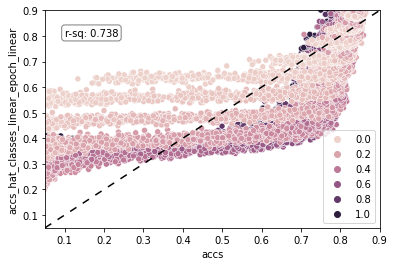

0.7378271790208146
mean val loss: 0.023044789594509556


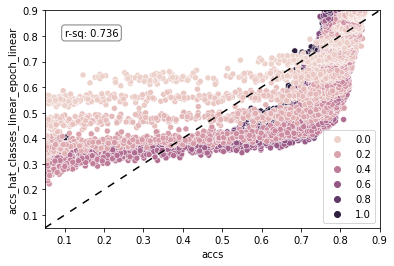

r_square val: 0.7362026352154162


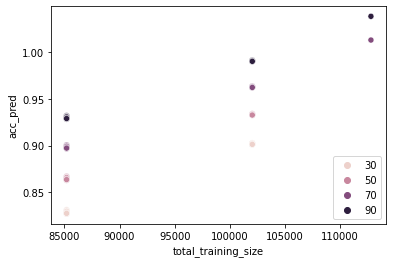

,training_times,0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,d,e,f,g,h,n,q,r,t,epochs_trained,total_training_size,acc_pred
0,100.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,90,112800.0,1.038377
1,45.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,70,112800.0,1.013006
2,100.0,2400.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,90,102040.0,0.990926
3,100.0,2400.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,70,102040.0,0.963023
4,100.0,2400.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,2120.0,50,102040.0,0.933505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,100.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,2400.0,1800.0,30,85200.0,0.828187
374,100.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,2400.0,90,85200.0,0.928923
375,100.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,2400.0,70,85200.0,0.897294
376,100.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,1800.0,2400.0,50,85200.0,0.863559


In [20]:
#def plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_pred, results_pred_orig, saving_plots=False, is_2param=False):
# some plotting parameters
saving_plots = False
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
param_df = param_df.set_index("param_name").T
HTML(display(param_df))
print(param_df.to_latex(float_format="{:.2f}".format))
y_hat = func(xdata, *params)
print(((y_hat - y)**2).mean())
# dataframe for plotting:
results[y_hat_name] = y_hat


sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}.jpg")
plt.show()
print(metrics.r2_score(results.accs, results[y_hat_name]))
# val data:
y_val_hat = func(xdata_val, *params)
print(f"mean val loss: {((y_val_hat - y_val)**2).mean()}")
# dataframe for plotting:
results_val[y_hat_name] = y_val_hat

sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
plt.xlim((0.05, 0.9))
plt.ylim((0.05, 0.9))
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
plt.legend(loc = 'lower right')
if saving_plots:
    plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_val.jpg")
plt.show()

print(f"r_square val: {metrics.r2_score(results_val.accs, results_val[y_hat_name])}")

acc_pred = func(xdata_pred, *params)
results_pred_orig["acc_pred"] = acc_pred
sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
plt.legend(loc = 'lower right')
plt.show()
display(results_pred_orig)


is_2param = False
if is_2param:
    param_unstacked = param_df.T.reset_index(drop=False).iloc[3:,:].param_name.str.split("_", expand=True).reset_index(drop=True)
    param_unstacked.columns = ["feature", "param_no"]
    param_unstacked["param_value"] = param_df.T.reset_index(drop=False).iloc[3:,:].reset_index(drop=True).param_value
    param_unstacked = param_unstacked.set_index(["feature", "param_no"])
    param_unstacked = param_unstacked.unstack()
    display(param_unstacked)

    param_unstacked.iloc[:,1]
    plt.scatter(param_unstacked.iloc[:,0], param_unstacked.iloc[:,1])
    plt.xlabel("parameter height")
    plt.ylabel("parameter width")
    for i in range(param_unstacked.shape[0]):
        plt.annotate(param_unstacked.reset_index().iloc[i,0], (param_unstacked.iloc[i,0] + 0.01, param_unstacked.iloc[i, 1]))
    if saving_plots:
        plt.savefig(f"paper/plots/{model_type}_{y_hat_name}_param1_vs_param2.jpg")
    plt.show()



### using an arctan effect for every class:

In [ ]:
y_hat_name = "accs_hat_classes_arctan_epoch_artan"

def func(x, a: float, b: float, c: float, d0:float, d0_2:float, d1:float, d1_2:float, d2:float, d2_2:float, d3:float, d3_2:float, d4:float, d4_2:float, d5:float, d5_2:float, d6:float, d6_2:float, d7:float, d7_2:float, d8:float, d8_2:float, d9:float, d9_2:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**b) * c

np.random.seed(seed=42135230)
n_p = 25
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 50))
    converged = True
except:
    print("did not converge")



In [ ]:
param_names = ["a", "b", "c"]
for c in classes:
    param_names = param_names + [f"{c}_1", f"{c}_2"]
param_names = param_names + ["epoch_1", "epoch_2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=True)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    


# all class counts linear, but including quadratic term for epoch:

In [ ]:
y_hat_name = "accs_hat_classes_linear_epoch_sq"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c

np.random.seed(seed=42132457)
n_p = 15
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

In [ ]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "epoch**2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    


# using all epochs, but just overall training dataset size:

In [ ]:
#
y_hat_name = "accs_hat_total_n_epoch"

def func(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float) -> float:
    x_epoch = x[10]
    x_total_n = x[11]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c

np.random.seed(seed=4342133)
n_p = 5
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

In [ ]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n", "epoch"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    


### Using the arctan trick also for the total_n model:

In [ ]:
y_hat_name = "accs_hat_total_n_arctan_epoch_arctan"

def func(x, a: float, b: float, c: float, d_total_n:float, d_total_n_2:float, d_epochs:float, d_epochs_2:float) -> float:
    x_epoch = x[10]
    x_total_n = x[11]
    return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c

np.random.seed(seed=92548)
n_p = 7
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

In [ ]:
param_names = ["a", "b", "c"]
param_names = param_names + ["total_n_1", "total_n_2", "epoch_1", "epoch_2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)
    results = plotting_printing.forward_testing(results_orig, results_orig, results, func, n_p, xdata, y, xdata, y_hat_name)
    plotting_printing.plot_forward_testing(results, y_hat_name)
    results_val = plotting_printing.forward_testing(results_orig, results_val_orig, results_val, func, n_p, xdata, y, xdata_val, y_hat_name)
    plotting_printing.plot_forward_testing(results_val, y_hat_name)
    
